<a href="https://colab.research.google.com/github/beercafeguy/PyMLLab/blob/master/ML_A_Z/nlp/NLP_BOW_Cart_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! ls -ltr /content/drive/MyDrive/ML_A_Z/Part_7_Natural_Language_Processing/Section_36_Natural_Language_Processing/Python/Restaurant_Reviews.tsv

-rw------- 1 root root 61332 May 18  2020 /content/drive/MyDrive/ML_A_Z/Part_7_Natural_Language_Processing/Section_36_Natural_Language_Processing/Python/Restaurant_Reviews.tsv


In [4]:
path = "/content/drive/MyDrive/ML_A_Z/Part_7_Natural_Language_Processing/Section_36_Natural_Language_Processing/Python/Restaurant_Reviews.tsv"
df = pd.read_csv(path,delimiter="\t",quoting=3)
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Data Cleaning

In [5]:
import re
import nltk

nltk.download('stopwords')


from nltk.corpus import stopwords # get stop words which are not usefull for NLP like "a","the" etc.
from nltk.stem.porter import PorterStemmer # take only root word

corpus = []

for i in range(0,df.shape[0]):
  review = re.sub("[^a-zA-z]"," ",df['Review'][i]) # regex replace all non letters by space
  review = " ".join(review.split()) # remove extra spaces
  review = review.lower()
  review_words = review.split(" ")
  ps = PorterStemmer()
  all_sw = set(stopwords.words('english'))
  all_sw.remove("not")
  review_stemmed = [ps.stem(word) for word in review_words if not word in all_sw] # stem words after removing stopwords like I he she etc
  review = " ".join(review_stemmed)
  corpus.append(review)
  #print(review_stemmed)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
print(corpus[0:5])

['wow love place', 'crust not good', 'not tasti textur nasti', 'stop late may bank holiday rick steve recommend love', 'select menu great price']


Create Bag of Words model

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:,-1].values

In [15]:
print(len(X[2])) # number of words in BAG

1500


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import train_test_split

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
import graphviz # for plotting decision tree graphs



In [20]:
def fitting(X, y, criterion, splitter, mdepth, clweight, minleaf):

    # Create training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Fit the model
    model = tree.DecisionTreeClassifier(criterion=criterion,
                                        splitter=splitter,
                                        max_depth=mdepth,
                                        class_weight=clweight,
                                        min_samples_leaf=minleaf,
                                        random_state=0,
                                  )
    clf = model.fit(X_train, y_train)

    # Predict class labels on training data
    pred_labels_tr = model.predict(X_train)
    # Predict class labels on a test data
    pred_labels_te = model.predict(X_test)

    # Tree summary and model evaluation metrics
    print('*************** Tree Summary ***************')
    print('Classes: ', clf.classes_)
    print('Tree Depth: ', clf.tree_.max_depth)
    print('No. of leaves: ', clf.tree_.n_leaves)
    print('No. of features: ', clf.n_features_in_)
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Test Data ***************')
    score_te = model.score(X_test, y_test)
    print('Accuracy Score: ', score_te)
    # Look at classification report to evaluate the model
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("")

    print('*************** Evaluation on Training Data ***************')
    score_tr = model.score(X_train, y_train)
    print('Accuracy Score: ', score_tr)
    # Look at classification report to evaluate the model
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')

    # Use graphviz to plot the tree
    dot_data = tree.export_graphviz(clf, out_file=None,
                                #feature_names=X.columns,
                                class_names=[str(list(clf.classes_)[0]), str(list(clf.classes_)[1])],
                                filled=True,
                                rounded=True,
                                #rotate=True,
                               )
    graph = graphviz.Source(dot_data)

    # Return relevant data for chart plotting
    return X_train, X_test, y_train, y_test, clf, graph

In [21]:
def Plot_3D(X, X_test, y_test, clf, x1, x2, mesh_size, margin):

    # Specify a size of the mesh to be used
    mesh_size=mesh_size
    margin=margin

    # Create a mesh grid on which we will run our model
    x_min, x_max = X.iloc[:, 0].fillna(X.mean()).min() - margin, X.iloc[:, 0].fillna(X.mean()).max() + margin
    y_min, y_max = X.iloc[:, 1].fillna(X.mean()).min() - margin, X.iloc[:, 1].fillna(X.mean()).max() + margin
    xrange = np.arange(x_min, x_max, mesh_size)
    yrange = np.arange(y_min, y_max, mesh_size)
    xx, yy = np.meshgrid(xrange, yrange)

    # Calculate predictions on grid
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    # Create a 3D scatter plot with predictions
    fig = px.scatter_3d(x=X_test[x1], y=X_test[x2], z=y_test,
                     opacity=0.8, color_discrete_sequence=['black'])

    # Set figure title and colors
    fig.update_layout(#title_text="Scatter 3D Plot with CART Prediction Surface",
                      paper_bgcolor = 'white',
                      scene = dict(xaxis=dict(title=x1,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'),
                                   yaxis=dict(title=x2,
                                              backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0'
                                              ),
                                   zaxis=dict(title='Probability of Rain Tomorrow',
                                              backgroundcolor='lightgrey',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              )))

    # Update marker size
    fig.update_traces(marker=dict(size=1))

    # Add prediction plane
    fig.add_traces(go.Surface(x=xrange, y=yrange, z=Z, name='CART Prediction',
                              colorscale='Jet',
                              reversescale=True,
                              showscale=False,
                              contours = {"z": {"show": True, "start": 0.5, "end": 0.9, "size": 0.5}}))
    fig.show()
    return fig

In [22]:
# Fit the model and display results
X_train, X_test, y_train, y_test, clf, graph = fitting(X, y, 'gini', 'best',
                                                       mdepth=3,
                                                       clweight=None,
                                                       minleaf=1000)

*************** Tree Summary ***************
Classes:  [0 1]
Tree Depth:  0
No. of leaves:  1
No. of features:  1500
--------------------------------------------------------

*************** Evaluation on Test Data ***************
Accuracy Score:  0.485
              precision    recall  f1-score   support

           0       0.48      1.00      0.65        97
           1       0.00      0.00      0.00       103

    accuracy                           0.48       200
   macro avg       0.24      0.50      0.33       200
weighted avg       0.24      0.48      0.32       200

--------------------------------------------------------

*************** Evaluation on Training Data ***************
Accuracy Score:  0.50375
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       403
           1       0.00      0.00      0.00       397

    accuracy                           0.50       800
   macro avg       0.25      0.50      0.33       800
weig

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

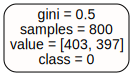

In [23]:
graph